# Model 9: Demography and cultural gain / loss

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model9.html

- 人口サイズが減少すると文化的特性を失いやすくなる。(Henrich, 2004)
- 基本的に前世代の最高スコア$z_h$をコピーするが、2種類のエラーを設ける。
    1. alpha だけ劣化する。
    2. [ガンベル分布](https://ja.wikipedia.org/wiki/%E3%82%AC%E3%83%B3%E3%83%99%E3%83%AB%E5%88%86%E5%B8%83)でばらつかせる。

In [1]:
include("src/Agent.jl")
include("src/Output.jl")
using .Agent
using .Output

using Statistics
using Plots

In [2]:
function gumbel(n::Int, a::Float64, beta::Float64)::Vector{Float64}
    a .+ beta .* (-log.(-log.(rand(n))))
end

function demography(; N::Int, r_max::Int, t_max::Int, alpha::Float64, beta::Float64)::Plots.Plot
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        traits = gumbel(N, 0.0, beta)

        for t = 1:t_max
            z_bar = mean(traits)
            
            if t > 1
                z_h = maximum(traits)
                traits = gumbel(N, z_h - alpha, beta)
            end

            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = mean(traits)
        end
    end

    p = plot(
        output_df[output_df.r.== 1, :].p,
        title = "N = $N, alpha = $alpha, beta = $beta",
        xlabel = "generation",
        ylabel = "mean trait value z",
        legend = false
    )
    for r = 2:maximum(output_df.r)
        plot!(output_df[output_df.r.== r, :].p)
    end
    
    return p
end;

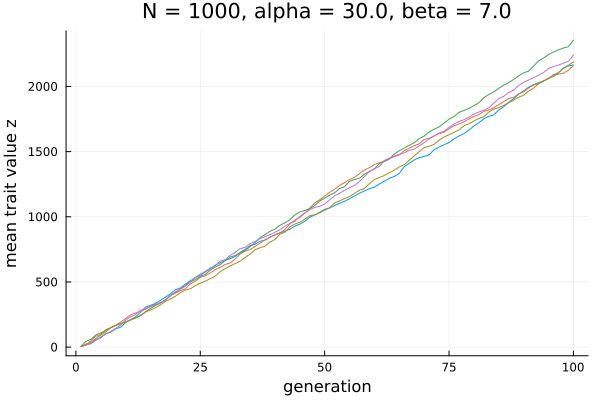

In [3]:
demography(N = 1000, r_max = 5, t_max = 100, alpha = 30.0, beta = 7.0)

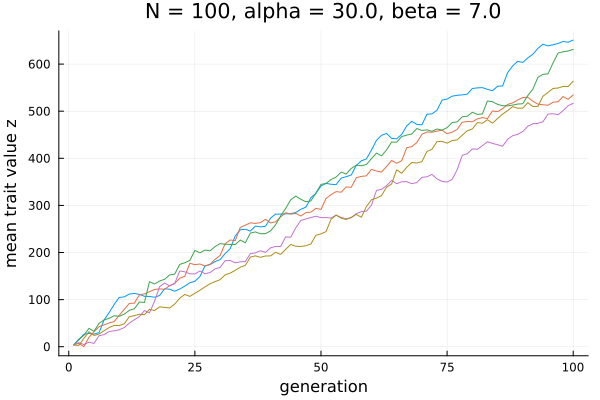

In [4]:
demography(N = 100, r_max = 5, t_max = 100, alpha = 30.0, beta = 7.0)

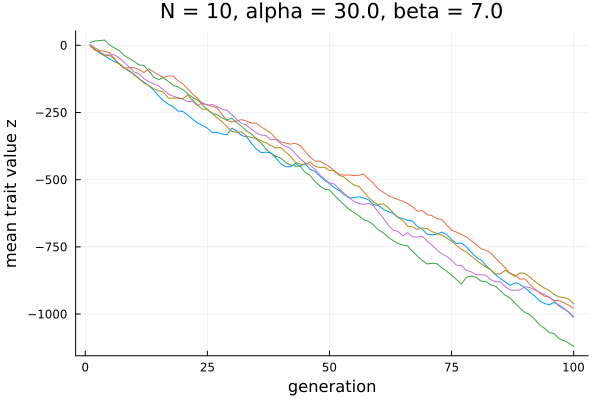

In [5]:
demography(N = 10, r_max = 5, t_max = 100, alpha = 30.0, beta = 7.0)

In [6]:
function demography_diff(; N_max::Int, t_max::Int, alpha::Float64, beta::Float64)::Vector{Float64}
    outputs = fill(0.0, N_max)

    for N = 1:N_max
        traits = gumbel(N, 0.0, beta)

        for t = 1:t_max
            z_bar = mean(traits)
            z_h = maximum(traits)
            traits = gumbel(N, z_h - alpha, beta)
            outputs[N] = outputs[N] + mean(traits) - z_bar
        end

        outputs[N] = outputs[N] / t_max
    end

    outputs
end;

In [7]:
data1 = demography_diff(N_max = 5000, t_max = 100, alpha = 7.0, beta = 1.0)
data2 = demography_diff(N_max = 5000, t_max = 100, alpha = 9.0, beta = 1.0);

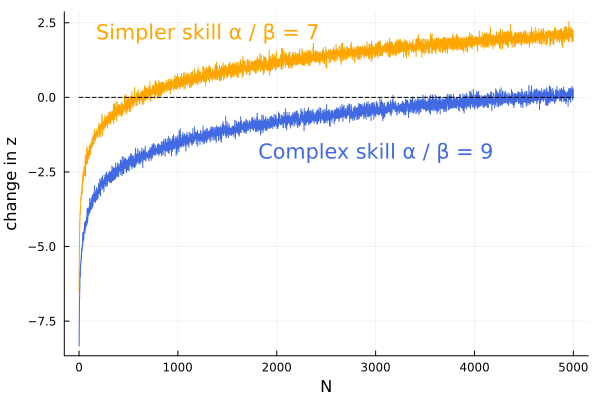

In [8]:
plot(data1, lc = :orange, xlabel = "N", ylabel = "change in z", legend = false)
plot!(data2, lc = :royalblue)
plot!(fill(0, length(data1)), line=:dash, color=:black)

annotate!(1300, 2.2, text("Simpler skill α / β = 7", :orange))
annotate!(3000, -1.8, text("Complex skill α / β = 9", :royalblue))

## Analytic Appendix

- There are $N$ individuals, each individual $i$ has a trait value $z_i$, the highest trait value among population is $z_h$, and the mean value is $\bar{z}$.
- Each individual of each new generation draws a trait value from the gumbel distribution shown above, with mode $z_h − \alpha$ and dispersion $\beta$.
- We want to calculate $\Delta\bar{z}$, the change in the mean trait value from one generation to the next.

$$
\begin{eqnarray}
\bar{z}'   &=& z_h + \Delta z_h               \tag{9.1} \\
z_h        &=& a + \beta (\epsilon + \ln(N))  \tag{9.2} \\
\Delta z_h &=& a + \beta \epsilon - a - \alpha \\
           &=& - \alpha + \beta \epsilon      \tag{9.3} \\
\Delta\bar{z} &=& - \alpha + \beta (\epsilon + \ln(N))  \tag{9.4} \\
\end{eqnarray}
$$

- When $\Delta\bar{z} = 0$,
$$
N^* = e^{(\frac{\alpha}{\beta} - \epsilon)}  \tag{9.5} \\
$$